In [171]:
import findspark
findspark.init()

In [172]:
from pyspark.sql import SparkSession
from pyspark.sql import *

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [192]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema =True)

df.printSchema()
#display(df.dtypes)
#df.show(5)
#df.describe().show(5)
#display(df.limit(10))
#df.limit().toPandas()
#import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)


root
 |-- Job_ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting_Type: string (nullable = true)
 |-- #_Of_Positions: integer (nullable = true)
 |-- Business_Title: string (nullable = true)
 |-- Civil_Service_Title: string (nullable = true)
 |-- Title_Code_No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job_Category: string (nullable = true)
 |-- Full_Time_Part_Time_indicator: string (nullable = true)
 |-- Salary_Range_From: double (nullable = true)
 |-- Salary_Range_To: double (nullable = true)
 |-- Salary_Frequency: string (nullable = true)
 |-- Work_Location: string (nullable = true)
 |-- Division_Work_Unit: string (nullable = true)
 |-- Job_Description: string (nullable = true)
 |-- Minimum_Qual_Requirements: string (nullable = true)
 |-- Preferred_Skills: string (nullable = true)
 |-- Additional_Information: string (nullable = true)
 |-- To_Apply: string (nullable = true)
 |-- Hours_Shift: string (nullable = true)
 |-- Work_Locat

### Column Types

In [174]:
num_cols = [c for c, t in df.dtypes if t in ("int","double")]
cat_cols = [c for c, t in df.dtypes if t == "string"]

print("numerical :" ,num_cols)
print("categorical :" ,cat_cols)

numerical : ['Job ID', '# Of Positions', 'Salary Range From', 'Salary Range To']
categorical : ['Agency', 'Posting Type', 'Business Title', 'Civil Service Title', 'Title Code No', 'Level', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Frequency', 'Work Location', 'Division/Work Unit', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1', 'Recruitment Contact', 'Residency Requirement', 'Posting Date', 'Post Until', 'Posting Updated', 'Process Date']


### Data Check-up

In [175]:
from pyspark.sql.functions import col, sum

#check null values in data
df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(vertical=True)

#Salary freq exploratory
#df.select("Salary Frequency").distinct().show()

-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Location 1               | 1138 
 Recruitment Contact           | 1763 
 Residency Requirement         | 678  
 Posting Date            

###  Data clean-up

In [216]:
from pyspark.sql.functions import lower, regexp_replace,when

#column name cleanup
clean_cols = [c.replace(" ", "_").replace("-", "_").replace("/", "_") for c in df.columns]
df = df.toDF(*clean_cols)

#remove duplicate entries
df = df.dropDuplicates()

#Minimun qualification string  clean-up
df = df.withColumn("req_clean", lower(col("Minimum_Qual_Requirements")))
df = df.withColumn(
    "req_clean",
    regexp_replace("req_clean", "â€™|’", "'")
)
df = df.withColumn(
    "req_clean",
    regexp_replace("req_clean", "[^a-z0-9\\s']", " ")
)

#taking avg salary per jobs based on range
df = df.withColumn(
            "avg_salary",
            (col("Salary_Range_From") + col("Salary_Range_To"))/2
)

#only jobs with valid salary considered
df = df.filter(col("avg_salary") > 0)


#Annual salary column added for getting valid pay as per PAY FREQUENCY
df = df.withColumn(
    "annual_salary",
    when(col("Salary_Frequency") == "Annual", col("avg_salary"))
    .when(col("Salary_Frequency") == "Hourly", col("avg_salary") * 40 * 52) #ASSUMING 8 HOURS WORK PER DAY
    .when(col("Salary_Frequency") == "Daily", col("avg_salary") * 5 * 52)
    .when(col("Salary_Frequency") == "Weekly", col("avg_salary") * 52)
    .when(col("Salary_Frequency") == "Bi-Weekly", col("avg_salary") * 26)
    .when(col("Salary_Frequency") == "Monthly", col("avg_salary") * 12)
)

## KPI

### 1. No. of job postings per category (Top 10)

In [218]:
from pyspark.sql.functions import count

df.groupBy("Job_Category") \
.agg(count("*").alias("job_count")) \
.orderBy("job_count",ascending = False) \
.show(10)


+--------------------+---------+
|        Job_Category|job_count|
+--------------------+---------+
|Engineering, Arch...|      497|
|Technology, Data ...|      312|
|       Legal Affairs|      224|
|Public Safety, In...|      179|
|Building Operatio...|      177|
|Finance, Accounti...|      168|
|Administration & ...|      131|
|Constituent Servi...|      129|
|              Health|      125|
|Policy, Research ...|      124|
+--------------------+---------+
only showing top 10 rows



### 2.  Salary per job category

In [219]:
df.groupBy("Job_Category") \
.avg("annual_salary") \
.orderBy("avg(annual_salary)",ascending =False) \
.show(df.count())

+--------------------+------------------+
|        Job_Category|avg(annual_salary)|
+--------------------+------------------+
|Administration & ...|          218587.0|
|Engineering, Arch...|          198518.0|
|Engineering, Arch...|          196042.5|
|Health Policy, Re...|          128694.5|
|Engineering, Arch...|          128247.5|
|Engineering, Arch...|          128247.5|
|Constituent Servi...|          125280.4|
|Communications & ...|          125000.0|
|Constituent Servi...|122182.31999999999|
|Administration & ...|          118287.0|
|Constituent Servi...|          103680.5|
|Engineering, Arch...| 98257.79999999999|
|Technology, Data ...|          96373.45|
|Administration & ...|           95000.0|
|Administration & ...|           92500.0|
|Administration & ...|         91497.575|
|Administration & ...| 91174.22222222222|
|Administration & ...|           91000.0|
|Technology, Data ...| 90884.76317948718|
|Administration & ...|           90000.0|
|Engineering, Arch...| 89857.43548

### 3.Correlation between Degree and Salary 

In [220]:
from pyspark.sql.functions import when

df = df.withColumn(
    "degree_level",
    when(col("req_clean").rlike("phd|doctor"), "PhD")
    .when(col("req_clean").rlike("master"), "Master")
    .when(col("req_clean").rlike("bachelor"), "Bachelor")
    .otherwise("Other")
)

df.groupBy("degree_level") \
.avg("annual_salary") \
.show()

+------------+------------------+
|degree_level|avg(annual_salary)|
+------------+------------------+
|         PhD| 84900.66455696203|
|       Other| 73985.47031954888|
|      Master| 86484.89041259841|
|    Bachelor|103404.23561643835|
+------------+------------------+



### 4.Job posting having highest salary per Agency

In [221]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

w = Window.partitionBy("Agency").orderBy(col("annual_salary").desc())

df.withColumn("rank",row_number().over(w)) \
.filter("rank =1") \
.select("Agency","annual_salary") \
.orderBy("annual_salary",ascending = False) \
.show()

+--------------------+------------------+
|              Agency|     annual_salary|
+--------------------+------------------+
|DEPT OF ENVIRONME...|          218587.0|
|   POLICE DEPARTMENT|          217201.0|
|DISTRICT ATTORNEY...|          191913.0|
|NYC HOUSING AUTHO...|          180000.0|
|NYC EMPLOYEES RET...|          177374.5|
|DEPT OF HEALTH/ME...|         170133.84|
|OFFICE OF THE COM...|          167500.0|
|DEPARTMENT OF INV...|          165000.0|
|      LAW DEPARTMENT|          164104.0|
|DEPARTMENT OF SAN...|158038.40000000002|
|DEPT OF DESIGN & ...|          151795.0|
|DEPARTMENT FOR TH...|          150371.0|
|DEPT OF CITYWIDE ...|140171.19999999998|
|TAXI & LIMOUSINE ...|          140000.0|
|DEPARTMENT OF COR...|139105.09600000002|
|DEPT OF INFO TECH...|          138968.0|
|HOUSING PRESERVAT...|          135000.0|
|FINANCIAL INFO SV...|          135000.0|
|CONFLICTS OF INTE...|          135000.0|
|DEPT OF PARKS & R...|          128000.0|
+--------------------+------------

### 5. Job postings average salary per agency for past 2 years.

In [222]:
from pyspark.sql.functions import year, current_date ,to_timestamp,min

latest_df = df.select("*",to_timestamp(col("Posting_Date")).alias("posting_date_cleaned")) \
.filter(col("posting_date_cleaned").isNotNull())

latest_df = latest_df.filter(year(col("posting_date_cleaned")) >= year(current_date()) - 2)

latest_df.groupBy("Agency") \
.avg("annual_salary") \
.show()

+------+------------------+
|Agency|avg(annual_salary)|
+------+------------------+
+------+------------------+



In [226]:
#Analysis of source data reveals the skill sets mostly range in different domainof government.

df.select("Preferred_Skills").show(10,truncate =False)
df.select("Job_Description").show(10,truncate =False)

### 6. Highest paid skills in US

In [223]:
text_col = lower(col("Preferred_Skills"))

#used by 
skills = ["engineering","construction","project",
          "finance","legal","environmental",
          "administrative","health","water"]

results = []

for s in skills:
    avg_sal = df.filter(text_col.contains(s)) \
                .agg({"annual_salary":"avg"}) \
                .collect()[0][0]

    results.append((s, avg_sal))

skills_df = spark.createDataFrame(results, ["skill","avg_salary"]) \
     .orderBy("avg_salary", ascending=False) 

skills_df.show()

+--------------+-----------------+
|         skill|       avg_salary|
+--------------+-----------------+
|administrative|92946.80814285715|
|  construction|90928.66931092436|
|   engineering|90223.12809917355|
|       finance|88117.58333333333|
|       project| 84363.6309310345|
|         water|84092.20099009902|
| environmental| 80180.8090909091|
|        health| 79631.6848372093|
|         legal|78974.48558659217|
+--------------+-----------------+



### Writing the final data into Parquet

In [224]:
df.write.mode("overwrite").parquet("/output/nyc_jobs_curated")

# Visualisations 

## Top 10 Job Categories

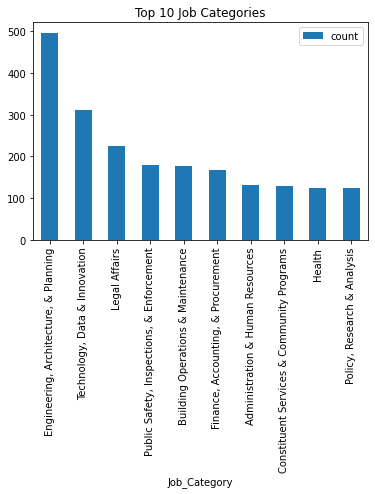

In [225]:
top10 = df.groupBy("Job_Category") \
          .count() \
          .orderBy("count", ascending=False) \
          .limit(10) \
          .toPandas()

import matplotlib.pyplot as plt

top10.plot(kind="bar", x="Job_Category", y="count")
plt.title("Top 10 Job Categories")
plt.show()

## Salary Distribution 

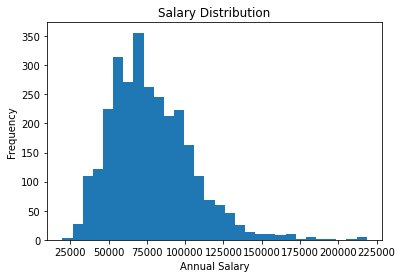

In [196]:
salary_pd = df.select("annual_salary") \
              .dropna() \
              .toPandas()

plt.figure()
plt.hist(salary_pd["annual_salary"], bins=30)
plt.title("Salary Distribution")
plt.xlabel("Annual Salary")
plt.ylabel("Frequency")
plt.show()

## Average Salary by Degree Levels

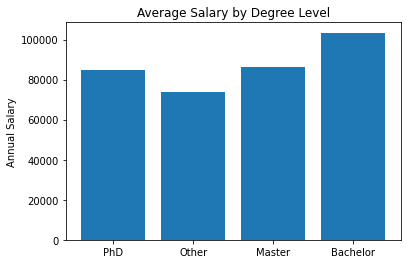

In [197]:
degree_pd = df.groupBy("degree_level") \
              .avg("annual_salary") \
              .toPandas()

plt.figure()
plt.bar(degree_pd["degree_level"], degree_pd["avg(annual_salary)"])
plt.title("Average Salary by Degree Level")
plt.ylabel("Annual Salary")
plt.show()

## Average Salary Trend with years

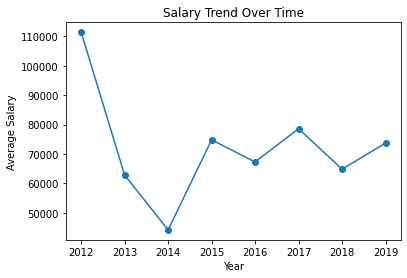

In [198]:
from pyspark.sql.functions import year

trend_pd = df.groupBy(year("posting_date").alias("year")) \
             .avg("annual_salary") \
             .orderBy("year") \
             .toPandas()

plt.figure()
plt.plot(trend_pd["year"], trend_pd["avg(annual_salary)"], marker="o")
plt.title("Salary Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.show()

## Highest Paid Skills

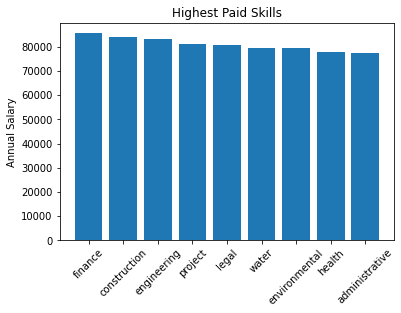

In [209]:
skills_pd = skills_df.orderBy("avg_salary", ascending=False) \
                     .limit(10) \
                     .toPandas()

plt.figure()
plt.bar(skills_pd["skill"], skills_pd["avg_salary"])
plt.title("Highest Paid Skills")
plt.xticks(rotation=45)
plt.ylabel("Annual Salary")
plt.show()